In [1]:
!pip install statsmodels yfinance pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 64.3 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for peewee: filename=peewee-3.17.0-cp310-cp310-linux_x86_64.whl size=290463 sha256=4b1647332bd9b63b3f8e9a6eeeea5b414dfcde950cbac44d42426d1ce2a23283
  Stored in directory: /root/.cache/pip/wheels/c7/70/ad/212867e96e7004265a69c4aa5dcff00a95f547a67ba26e7e76
Successfully built peewee


In [2]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')

# Data

We only need the closing price of NVDA itself to build an ARIMA model. We will use the data from the last 45 days to predict the price of the next 10 days (same as the previous notebook).

In [3]:
data = yf.download("NVDA")
data = data[['Close']][-45:].reset_index(drop=True)
data

[*********************100%%**********************]  1 of 1 completed


,Close
0,432.989990
1,469.670013
2,456.679993
3,471.160004
4,471.630005
5,460.179993
6,468.350006
7,487.839996
8,492.640015
9,493.549988


# Training

### Manual

We will analyse the data by ourselves and try to find the best parameters (p, d, q) for the ARIMA model.

First, check if the series is stationary using the Augmented Dickey-Fuller (ADF) test. If the p-value of the test is less than the significance level (0.05) then we reject the null hypothesis and infer that the time series is indeed stationary.

In [4]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(data['Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.361622
p-value: 0.600530


This means we need to difference the series to make it stationary.

In [5]:
# 1st Differencing
first_diff = data.diff().dropna()
result = adfuller(first_diff['Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -7.572556
p-value: 0.000000


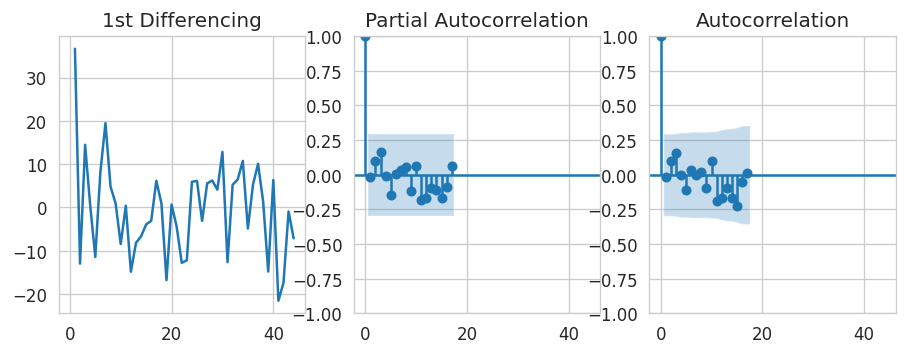

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 3, sharex=True)
axes[0].plot(first_diff); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(first_diff, ax=axes[1])
plot_acf(first_diff, ax=axes[2])

plt.show()

Since d=1 is enough to make the series stationary, we will use d=1.

We can then look at the ACF and PACF plots to find the best parameters for (p, q).

But instead of doing that which might lead to incorrect parameters, we will let the library find the best parameters for us.

### Auto

We will use the sktime library to find the best parameters (p, d, q) for the ARIMA model automatically.

In [7]:
from pmdarima.arima import auto_arima

y = data['Close'].values

model = auto_arima(y, random_state=42, suppress_warnings=True)
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   45
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -171.171
Date:                Sun, 22 Oct 2023   AIC                            348.342
Time:                        08:41:04   BIC                            353.762
Sample:                             0   HQIC                           350.363
                                 - 45                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     47.0413     41.706      1.128      0.259     -34.700     128.783
ar.L1          0.8938      0.092      9.696      0.000       0.713       1.074
sigma2       113.7518     21.295      5.342      0.0

# Inference

[*********************100%%**********************]  1 of 1 completed
[416.94432511 419.69205769 422.14788851 424.34282736 426.30458977
 428.05794692 429.62503848 431.02565213 432.27747342 433.39630912]


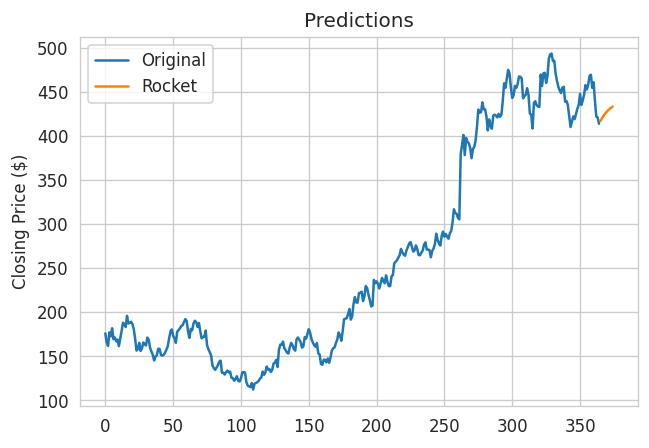

In [8]:
# Append the predictions to the original data frame
data = yf.download("NVDA")
data = data[['Close']].reset_index(drop=True)
original_data = data[-365:]['Close'].values

horizon = 10
y_pred = model.predict(horizon)

print(y_pred)

# Plot the predictions for both models
plt.figure(figsize=(6, 4))
plt.plot(original_data, label='Original')
plt.plot(np.arange(365, 365 + horizon), y_pred, label='Rocket')
plt.title('Predictions')
plt.ylabel('Closing Price ($)')
plt.legend()
plt.show()

So the ARIMA model predict the price of NVDA to keep going up in the next 10 days.

In [9]:
df_submission = pd.DataFrame(y_pred, columns=['Close'])
df_submission.index.name = 'index'
df_submission

,Close
index,
0,416.944325
1,419.692058
2,422.147889
3,424.342827
4,426.304590
5,428.057947
6,429.625038
7,431.025652
8,432.277473


In [10]:
df_submission.to_csv("submission.csv")